In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

%matplotlib notebook

In [2]:
import galsim
from mdetsims import PowerSpectrumPSF
import joblib

In [3]:
def _get_psf_variation(func, n=20):
    start = 0
    end = start + 225
    jobs = []
    
    fwhm = np.zeros((n, n))
    g1 = np.zeros((n, n))
    g2 = np.zeros((n, n))

    def __func(j, x):
        retvals = []
        for i, y in enumerate(np.linspace(start, end, n)):
            _psf = func(x, y)
            _psf = _psf.drawImage(scale=0.25, nx=17, ny=17)
            mom = galsim.hsm.FindAdaptiveMom(_psf)
            retvals.append((i, j, mom.moments_sigma * 0.25 * 2.355, 
                mom.observed_shape.g1, mom.observed_shape.g2))
        return retvals
    
    for j, x in enumerate(np.linspace(start, end, n)):
        jobs.append(joblib.delayed(__func)(j, x))
                          
    outputs = joblib.Parallel(
        n_jobs=-1, verbose=10, 
        max_nbytes=None, backend='loky')(jobs)
    for o in outputs:
        for i, j, _fwhm, _g1, _g2 in o:
            fwhm[i, j] = _fwhm
            g1[i, j] = _g1
            g2[i, j] = _g2

    return fwhm, g1, g2

In [4]:
from matplotlib.ticker import AutoMinorLocator

def plot_psf_model(fwhms, g1, g2, im_width, fig):
    """Plot a PSF model.

    Parameters
    ----------
    fwhms : np.ndarray, shape (im_width, im_width)
        A grid of the FWHM of the PSF model.
    g1 : np.ndarray, shape (im_width, im_width)
        The 1-component of the shape of the PSF.
    g2 : np.ndarray, shape (im_width, im_width)
        The 2-component of the shape of the PSF.
    im_width : int
        The width of the image in pixels.
    fig : matplotlib figure instance
        A figure to plot on.

    Examples
    --------
    >>> import matplotlib.pyplot as plt
    >>> import seaborn as sns
    >>> sns.set()
    >>> fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))
    >>> plot_psf_model(fwhm, g1, g2, 225, axs)
    """
    
    n = fwhms.shape[0]
    xt = []
    for i, _x in enumerate(np.linspace(0, im_width, n)):
        if i % 25 == 0 or i == 0 or i == n - 1:
            xt.append("%0.0f" % _x)
        else:
            xt.append('')

    kwargs = {
        'xticklabels': xt,
        'yticklabels': xt
    }

    ax = fig.add_subplot(2, 2, 1)
    sns.heatmap(
        fwhms, 
        square=True, 
        ax=ax,
        cbar_kws={'label': 'FWHM [arcsec]'},
        rasterized=True,
        **kwargs)
    ax.set_xlabel('column')
    ax.set_ylabel('row')

    whisker_kws = {
        'xtick.top': True,
        'xtick.direction': 'in',
        'ytick.right': True,
        'ytick.direction': 'in'}
    with sns.axes_style("ticks", whisker_kws):
        ax = fig.add_subplot(2, 2, 2)

        nmod = 10
        g = np.sqrt(g1**2 + g2**2)
        g /= np.mean(g)
        loc = np.linspace(0, im_width, n)
        beta = np.arctan2(g2, g1)/2
        ax.quiver(
            loc[::nmod],
            loc[::nmod],
            (g * np.cos(beta))[::nmod, ::nmod],
            (g * np.sin(beta))[::nmod, ::nmod],
            scale_units='xy',
            scale=0.075,
            headwidth=0,
            pivot='mid')
        ax.set_xlabel('column')
        ax.set_ylabel('row')
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.tick_params(axis='x', which='minor')
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        ax.tick_params(axis='y', which='minor')

    ax = fig.add_subplot(2, 2, 3)
    sns.heatmap(
        g1/1e-2, square=True, ax=ax, 
        cbar_kws={'label': '$10^{2}g_{1}$'},
        rasterized=True,
        **kwargs)
    ax.set_xlabel('column')
    ax.set_ylabel('row')

    ax = fig.add_subplot(2, 2, 4)
    sns.heatmap(
        g2/1e-2, square=True, ax=ax, 
        cbar_kws={'label': '$10^{2}g_{2}$'},
        rasterized=True,
        **kwargs)
    ax.set_xlabel('column')
    ax.set_ylabel('row')

In [5]:
psf = PowerSpectrumPSF(
    rng=np.random.RandomState(seed=10),
    im_width=225, 
    buff=225/2, 
    scale=0.263)

In [6]:
n = 225
func = lambda x,y: psf.getPSF(galsim.PositionD(x=x, y=y))

fwhm, g1, g2 = _get_psf_variation(func, n=n)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   30.9s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   35.6s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   40.2s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   46.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   51.9s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   

1.6431302828367491 0.33431859523808316 0.2701538019975488


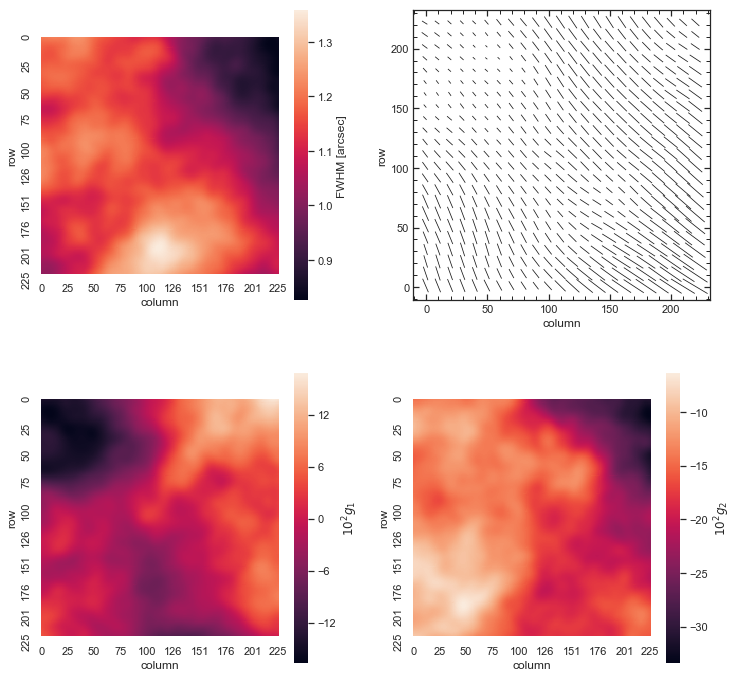

In [7]:
sns.set()
sns.set_context("notebook")

fig = plt.figure(figsize=(12, 12))
plot_psf_model(fwhm, g1, g2, 225, fig)
plt.subplots_adjust(wspace=0.25, hspace=0.25)
plt.savefig('../pspsf.pdf', bbox_inches='tight', pad_inches=0.1, dpi=400)

print(fwhm.max()/fwhm.min(), g1.max() - g1.min(), g2.max() - g2.min())